<a href="https://colab.research.google.com/github/Ronaldo192/Curso_terraform/blob/main/Analise_sentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import matplotlib as mp
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
# %matplotlib inline
import numpy as np
import tensorflow as tf

In [17]:
df_training = pd.read_csv('/content/review_clientes_melhores_compras.csv')
df_validation = pd.read_csv('/content/review_clientes_melhores_compras.csv')

In [18]:
df_training.head()

,review_id,review_cliente,sentimento
0,e64fb393e7b32834bb789ff8bb30750e,receber bem antar prazo estipular,1
1,f7c4243c7fe1938f181bec41a392bdeb,parabens melhores compras adorar comprar inter...,1
2,8670d52e15e00043ae7de4c01cc2fe06,recomendar aparelhar eficiente site marcar apa...,1
3,4b49719c8a200003f700d3d986ea1a19,pouco travar valor ta bom,1
4,3948b09f7c818e2d86c9a546758b2335,super recomendar vendedor confiavel produto ok...,1


In [19]:
training = df_training[['review_cliente', 'sentimento']].copy()
validation = df_training[['review_cliente', 'sentimento']].copy()

In [20]:
training.isnull().sum()

review_cliente    0
sentimento        0
dtype: int64

In [21]:
validation.isnull().sum()

review_cliente    0
sentimento        0
dtype: int64

In [22]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
VOCAB_SIZE = 1000

In [25]:
# Convert DataFrames to tf.data.Dataset objects
training_dataset = tf.data.Dataset.from_tensor_slices((training['review_cliente'], training['sentimento']))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation['review_cliente'], validation['sentimento']))

# Shuffle and batch the training dataset
training_dataset = training_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Batch the validation dataset
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [30]:
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=100)
encoder.adapt(training_dataset.map(lambda text, label: text))

model = tf.keras.Sequential([
  encoder,
  tf.keras.layers.Embedding(
  input_dim=len(encoder.get_vocabulary()),
  output_dim=64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1)
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (Text  (None, 100)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 100, 64)           64000     
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138369 (540.50 KB)
Trainable params: 13836

In [32]:
print(type(training))
print(training.shape)

<class 'pandas.core.frame.DataFrame'>
(42891, 2)


In [33]:
# Treinando o modelo
history = model.fit(training_dataset, epochs=10,
validation_data=validation_dataset,
validation_steps=30)

Epoch 1/10
671/671 [==============================] - 145s 201ms/step - loss: 0.4150 - accuracy: 0.7506 - val_loss: 0.2835 - val_accuracy: 0.9057
Epoch 2/10
671/671 [==============================] - 130s 194ms/step - loss: 0.2736 - accuracy: 0.8957 - val_loss: 0.2604 - val_accuracy: 0.9068
Epoch 3/10
671/671 [==============================] - 129s 192ms/step - loss: 0.2589 - accuracy: 0.9018 - val_loss: 0.2524 - val_accuracy: 0.9073
Epoch 4/10
671/671 [==============================] - 128s 191ms/step - loss: 0.2527 - accuracy: 0.9056 - val_loss: 0.2536 - val_accuracy: 0.9104
Epoch 5/10
671/671 [==============================] - 130s 194ms/step - loss: 0.2487 - accuracy: 0.9077 - val_loss: 0.2496 - val_accuracy: 0.9099
Epoch 6/10
671/671 [==============================] - 129s 193ms/step - loss: 0.2458 - accuracy: 0.9084 - val_loss: 0.2457 - val_accuracy: 0.9089
Epoch 7/10
671/671 [==============================] - 131s 195ms/step - loss: 0.2431 - accuracy: 0.9090 - val_loss: 0.2460 -

In [34]:
# Validando o modelo
test_loss, test_acc = model.evaluate(validation_dataset)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

671/671 [==============================] - 37s 55ms/step - loss: 0.2304 - accuracy: 0.9132
Test Loss: 0.23036041855812073
Test Accuracy: 0.9131985902786255


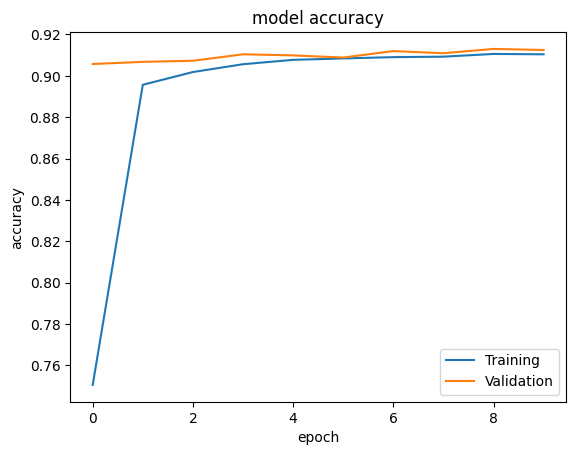

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

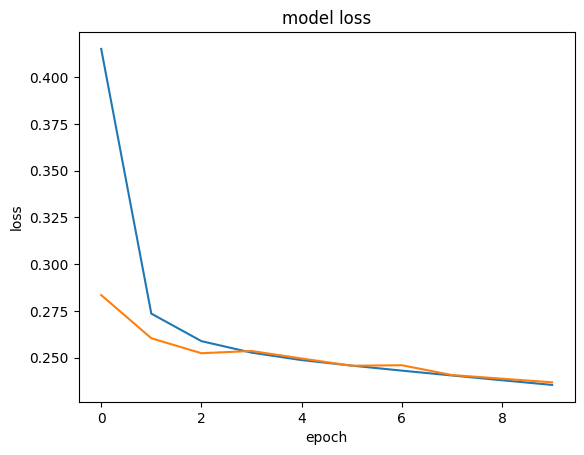

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [39]:
# Realizando uma predição
sample_text = ('	parabens melhores compras adorar comprar internet segurar pratico parabens todo feliz pascoa'
'	pouco travar valor ta bom'
)
predictions=model.predict(np.array([sample_text]))

if predictions > 0:
  print(f"avaliacao positiva: {predictions}")
else:
  print(f"avaliacao negatica: {predictions}")

1/1 [==============================] - 0s 67ms/step
avaliacao positiva: [[5.793924]]


In [40]:
# Realizando uma predição
sample_text = (' insatisfeito com produto, ruim'
'	nao gostei'
)
predictions=model.predict(np.array([sample_text]))

if predictions > 0:
  print(f"avaliacao positiva: {predictions}")
else:
  print(f"avaliacao negatica: {predictions}")

1/1 [==============================] - 0s 38ms/step
avaliacao negatica: [[-6.78942]]
